### Imports

In [193]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [194]:
%matplotlib inline

sns.set(rc={'figure.figsize': (12,8)})

warnings.filterwarnings('ignore')

### Importando os dados

- Músicas para clusterizar

In [195]:
df_songs = pd.read_csv('datasets/songs_to_cluster.csv')
df_songs.head(3)

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,0.666,0.859,0.000000,8,0.3140,-3.836,1,0.0304,156.990,0.933
1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,0.707,0.851,0.000094,7,0.3300,-5.008,0,0.0322,153.929,0.871
2,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,0.299,0.159,0.000000,11,0.0611,-16.540,0,0.0357,183.227,0.180


In [196]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
album               6500 non-null object
album_id            6500 non-null object
artist              6500 non-null object
artist_id           6500 non-null object
duration_ms         6500 non-null int64
id                  6500 non-null object
name                6500 non-null object
popularity          6500 non-null int64
acousticness        6500 non-null float64
danceability        6500 non-null float64
energy              6500 non-null float64
instrumentalness    6500 non-null float64
key                 6500 non-null int64
liveness            6500 non-null float64
loudness            6500 non-null float64
mode                6500 non-null int64
speechiness         6500 non-null float64
tempo               6500 non-null float64
valence             6500 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 964.9+ KB


In [197]:
df_songs.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,6.500000e+03,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,2.208090e+05,48.984308,0.293562,0.605050,0.661835,0.101119,5.283692,0.223859,-7.621361,0.641692,0.089147,123.111848,0.540776
std,8.607416e+04,20.803480,0.298453,0.166257,0.232170,0.251975,3.572666,0.209840,4.429930,0.479540,0.089175,28.578793,0.253939
min,4.544000e+04,0.000000,0.000002,0.000000,0.000255,0.000000,0.000000,0.020900,-42.238000,0.000000,0.000000,0.000000,0.000000
25%,1.760972e+05,37.000000,0.022700,0.495000,0.506000,0.000000,2.000000,0.094800,-9.358000,0.000000,0.037800,99.988750,0.340000
50%,2.071930e+05,52.000000,0.193000,0.619000,0.702000,0.000008,5.000000,0.132000,-6.577500,1.000000,0.054200,124.675500,0.548000
75%,2.461378e+05,63.000000,0.513000,0.727000,0.855000,0.005110,8.000000,0.284000,-4.699000,1.000000,0.099325,140.068000,0.750000
max,3.128960e+06,100.000000,0.996000,0.981000,0.999000,0.982000,11.000000,0.989000,0.858000,1.000000,0.904000,210.466000,0.984000


- Músicas do usuário

In [198]:
df_user = pd.read_csv('datasets/user_songs/belzedu_songs.csv')
df_user.head(3)

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Self-Titled,7jhH139X9JCMwKlW0SWwLY,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,228000,71QKtFaECvOxpvHk105FMw,Ocean,38,0.002000,0.555,0.723,0.00378,9,0.0589,-6.485,1,0.0420,122.003,0.348
1,Kaiju,0Z0fNb1sXiQ7oULwQYZMUA,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,230653,3GHB3jMQPJ6Q97JKbZCowT,Nagoya,46,0.000725,0.541,0.569,0.20600,7,0.0873,-8.497,1,0.0251,150.178,0.215
2,Sweet FA,1lhF5c8Q9bzYNwGFwQgYnP,Peach Pit,6fC2AcsQtd9h4BWELbbire,287080,0ZK8TGOsngrstVPsnrHbK1,Peach Pit,68,0.003220,0.515,0.804,0.00229,6,0.1490,-5.345,0,0.0398,123.969,0.298


In [199]:
if df_user.shape[0] > 500:
    df_user = df_user.sample(n=500, random_state=42)

In [200]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 19 columns):
album               343 non-null object
album_id            343 non-null object
artist              343 non-null object
artist_id           343 non-null object
duration_ms         343 non-null int64
id                  343 non-null object
name                343 non-null object
popularity          343 non-null int64
acousticness        343 non-null float64
danceability        343 non-null float64
energy              343 non-null float64
instrumentalness    343 non-null float64
key                 343 non-null int64
liveness            343 non-null float64
loudness            343 non-null float64
mode                343 non-null int64
speechiness         343 non-null float64
tempo               343 non-null float64
valence             343 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 51.0+ KB


In [201]:
df_user.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,236476.329446,38.533528,0.227179,0.573688,0.681572,0.113768,5.769679,0.192842,-7.083764,0.539359,0.095445,124.143892,0.524245
std,83356.043020,26.861752,0.267362,0.171749,0.201558,0.244916,3.613977,0.161659,3.261195,0.499177,0.101211,27.962681,0.231183
min,99226.000000,0.000000,0.000009,0.181000,0.007560,0.000000,0.000000,0.018800,-26.440000,0.000000,0.024500,51.539000,0.037200
25%,191831.500000,8.000000,0.010100,0.449000,0.549500,0.000000,2.000000,0.093850,-8.466000,0.000000,0.036850,102.031000,0.331500
50%,218586.000000,45.000000,0.107000,0.553000,0.707000,0.000172,6.000000,0.123000,-6.336000,1.000000,0.052500,124.917000,0.534000
75%,258643.000000,61.500000,0.355500,0.688500,0.852000,0.055150,9.000000,0.254000,-5.075000,1.000000,0.096100,142.010500,0.723500
max,875306.000000,84.000000,0.979000,0.968000,0.996000,0.948000,11.000000,0.928000,-1.400000,1.000000,0.786000,209.896000,0.972000


### Análise do dataset de treino

- Checando colunas

In [202]:
df_songs.columns

Index(['album', 'album_id', 'artist', 'artist_id', 'duration_ms', 'id', 'name',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

- Verificando correlações entre as variaveis

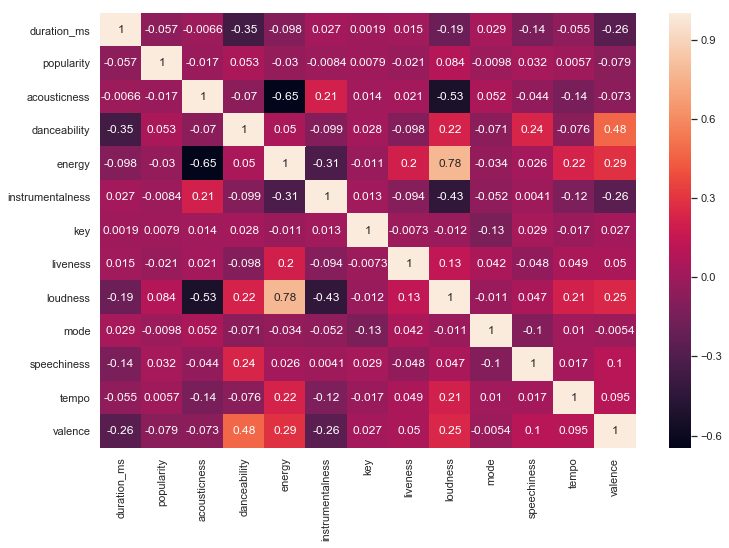

In [203]:
sns.heatmap(df_songs.corr(), annot=True)
plt.show()

- Analisando as distribuições das variáveis numericas

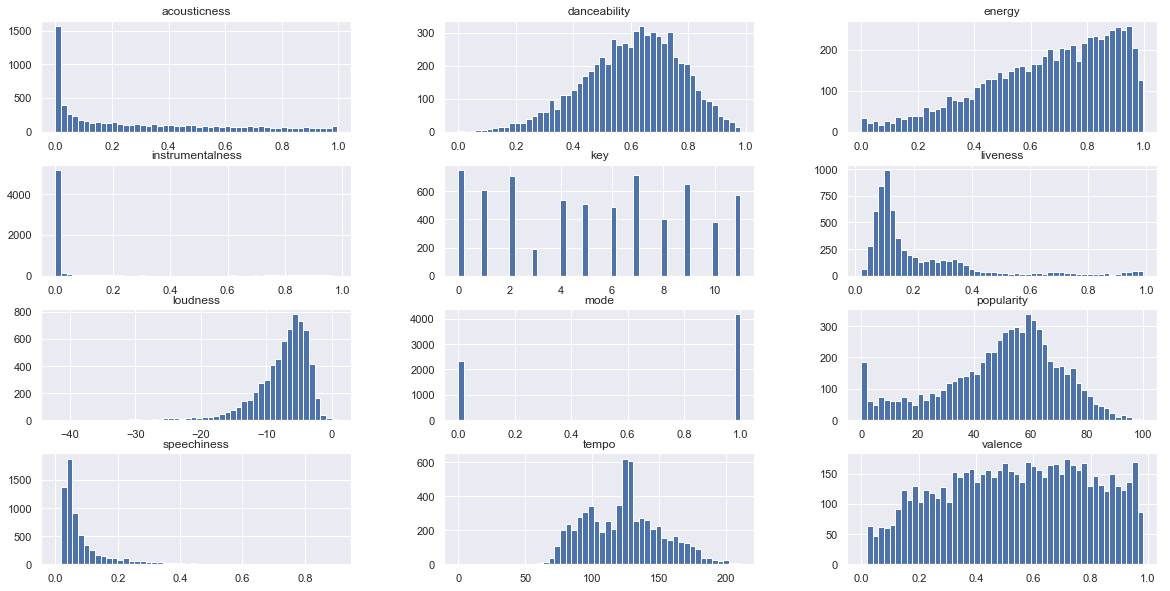

In [204]:
df_songs[['popularity', 'acousticness', 'danceability', 'energy', 
           'instrumentalness', 'key','liveness','loudness', 'mode', 'speechiness',
           'tempo', 'valence']].hist(bins=50, figsize=(20,10))
plt.show()

### Preprocessando os dados

- Mudando a escala dos dados

Usando Standard Scaler

In [151]:
columns_to_cluster = ['acousticness', 'danceability', 'energy',
                      'instrumentalness','liveness', 'speechiness', 'valence']

ss = StandardScaler()

songs_scaled = ss.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = ss.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [ 0.39351789  0.36662849  0.84929458 -0.40133461  0.42960597 -0.65883238
  1.54467758]
Dados de usuários:  [-0.84345475 -0.10896899  0.20583811 -0.44974244 -0.82975614 -0.52882419
 -0.7634763 ]


Usando Min Max Scaler

In [208]:
columns_to_cluster = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness',
                      'liveness','loudness', 'speechiness', 'valence']

mms = MinMaxScaler()

songs_scaled = mms.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = mms.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [0.37       0.41264952 0.67889908 0.85982408 0.         0.30275798
 0.89108038 0.03362832 0.94817073]
Dados de usuários:  [0.45238095 0.00203389 0.47522236 0.72380721 0.00398734 0.04410471
 0.79692492 0.02298096 0.33247754]


- Heatmap scaled

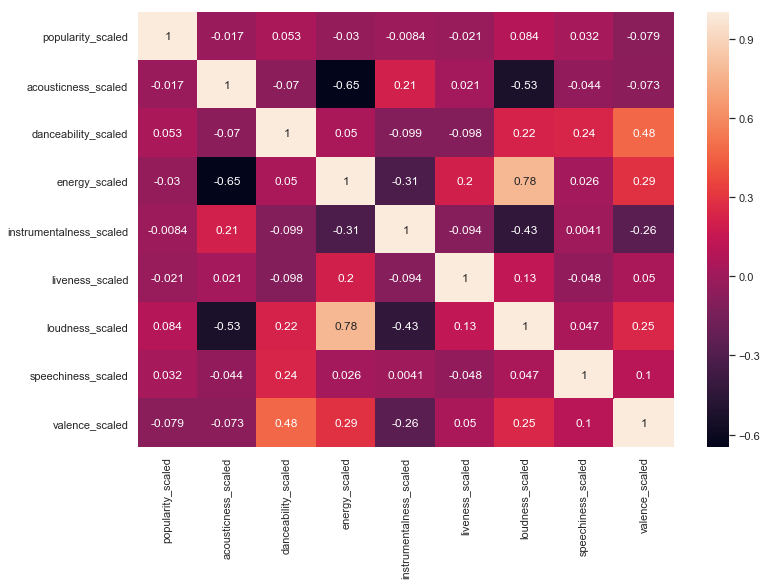

In [256]:
columns_to_cluster_scaled = ['popularity_scaled', 'acousticness_scaled', 'danceability_scaled', 
                             'energy_scaled', 'instrumentalness_scaled', 'liveness_scaled',
                             'loudness_scaled', 'speechiness_scaled', 'valence_scaled']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)
sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

### Desenvolvendo o modelo

In [210]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.3012305504924181
Number of Clusters = 3, Silhouette Score = 0.1908176898953157
Number of Clusters = 4, Silhouette Score = 0.19726218949463145
Number of Clusters = 5, Silhouette Score = 0.21503754737025266
Number of Clusters = 6, Silhouette Score = 0.2243945887385722
Number of Clusters = 7, Silhouette Score = 0.1978978626228579
Number of Clusters = 8, Silhouette Score = 0.1994331570974855
Number of Clusters = 9, Silhouette Score = 0.19311115329932965
Number of Clusters = 10, Silhouette Score = 0.19205432814298462
Number of Clusters = 11, Silhouette Score = 0.18377165294535258
Number of Clusters = 12, Silhouette Score = 0.18209997187329122
Number of Clusters = 13, Silhouette Score = 0.16974953656314448
Number of Clusters = 14, Silhouette Score = 0.17616334711793058
Number of Clusters = 15, Silhouette Score = 0.15953366253903123
Number of Clusters = 16, Silhouette Score = 0.16498047377381875
Number of Clusters = 17, Silhouette Score = 0.1613225

- Silhouette score plot

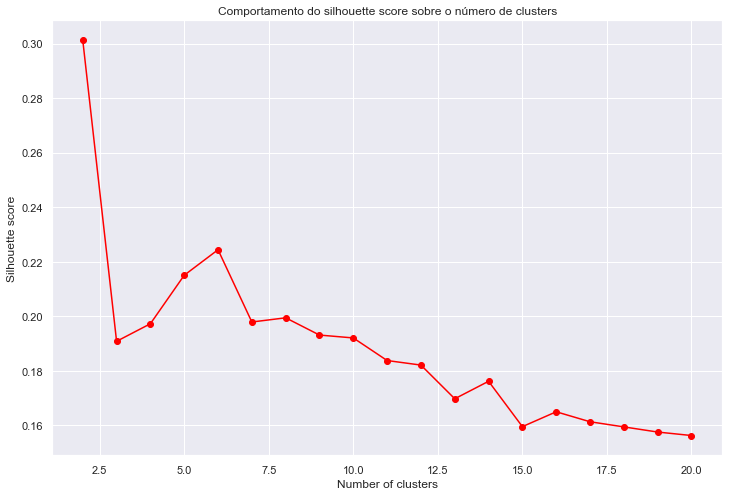

In [211]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Comportamento do silhouette score sobre o número de clusters')
plt.show()

- Elbow method plot

In [212]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 2054.478184043158
Number of Clusters = 3, Sum of Squared Distances = 1747.7117505662782
Number of Clusters = 4, Sum of Squared Distances = 1534.4945860038183
Number of Clusters = 5, Sum of Squared Distances = 1356.3322912391086
Number of Clusters = 6, Sum of Squared Distances = 1231.8743583363039
Number of Clusters = 7, Sum of Squared Distances = 1141.6010781122363
Number of Clusters = 8, Sum of Squared Distances = 1062.5578242896663
Number of Clusters = 9, Sum of Squared Distances = 1003.990169018867
Number of Clusters = 10, Sum of Squared Distances = 964.6402943933394
Number of Clusters = 11, Sum of Squared Distances = 925.5270046330388
Number of Clusters = 12, Sum of Squared Distances = 893.26074562849
Number of Clusters = 13, Sum of Squared Distances = 872.3399380237605
Number of Clusters = 14, Sum of Squared Distances = 849.4144367732132
Number of Clusters = 15, Sum of Squared Distances = 823.1591029292358
Number of Clusters = 16,

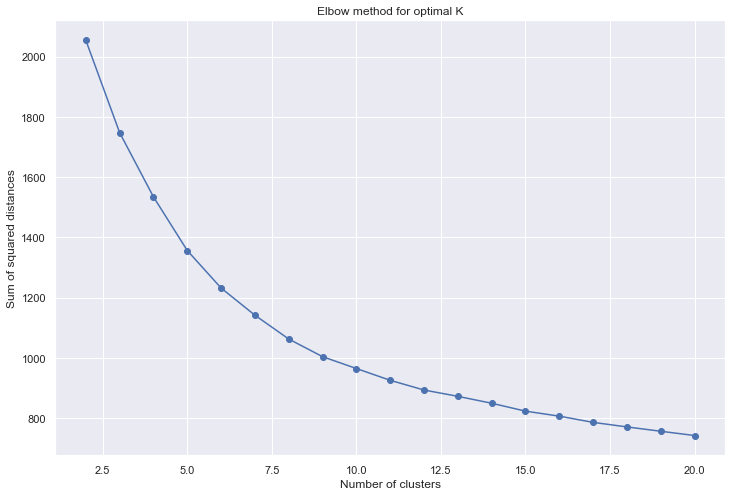

In [286]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [213]:
k=10

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 primeiros clusters: ', model.labels_[:10])

10 primeiros clusters:  [1 1 5 3 1 5 5 5 3 3]


### Visualizando os clusters

- Quantidade de músicas por cluster

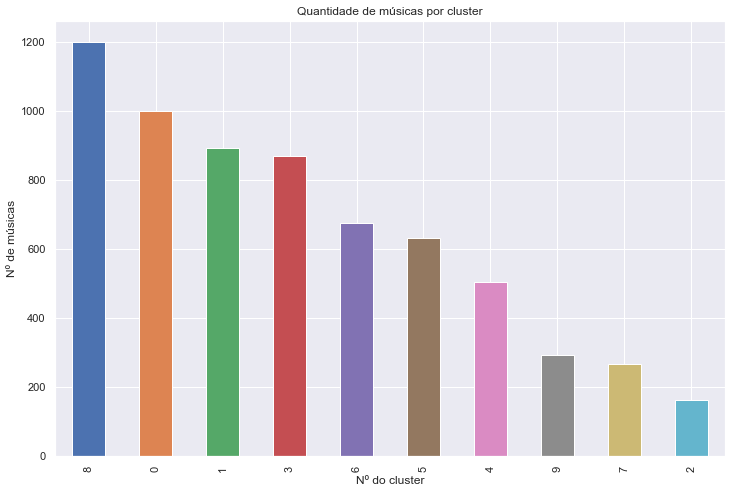

In [257]:
df_songs_scaled['cluster'] = model.labels_

df_songs_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Nº do cluster')
plt.ylabel('Nº de músicas')
plt.title('Quantidade de músicas por cluster')
plt.show()

In [258]:
display(df_songs_scaled['cluster'].value_counts())
minor_cluster = df_songs_scaled['cluster'].value_counts().tail(1)
print("Qtde. músicas no menor cluster: ", int(minor_cluster.values))

8    1201
0    1002
1     893
3     869
6     676
5     633
4     505
9     292
7     267
2     162
Name: cluster, dtype: int64

Qtde. músicas no menor cluster:  162


- Sample de músicas de cada cluster

In [259]:
df_songs_joined = pd.concat([df_songs,df_songs_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Joe Stone,Bug A Boo,Bug A Boo
0,zebrahead,"When Both Sides Suck, We're All Winners",Brain Invaders
0,GATTÜSO,Who We Are?,Who We Are?
0,D.O.D,According To Me - Cedric Gervais Remix,According To Me (Remixes)
0,Can't Swim,"""sometimes you meet the right people at the wr...",This Too Won't Pass
0,HELLYEAH,Perfect,Perfect
0,Legião Urbana,Será,Legião Urbana
0,Lloyd Cole and the Commotions,Rattlesnakes,Rattlesnakes
0,Linkin Park,What I've Done,Minutes to Midnight


,artist,name,album
cluster,,,
1,Aldous Harding,The Barrel,Designer
1,Harmonia Do Samba,Não Vai Ser Dessa Vez,Não Vai Ser Dessa Vez
1,Bezerra Da Silva,Aqueles Morros,Punhado de Bambas
1,Luanzinho Moraes,Fui brincar com fogo,Fui brincar com fogo
1,Mosquito,Que Mulher,Que Mulher
1,Teago Oliveira,Tudo Pode Ser,Boa Sorte
1,Cartola,Festa Da Vinda,Cartola (1974)
1,Saia Rodada,Decide Aí,Revigora
1,Gigante No Mic,Reis,Reis


,artist,name,album
cluster,,,
2,João Donato,Ê Lalá Lay-Ê,O Piano de João Donato
2,Jim Perkins,The Wooden King,The Wooden King
2,Mario Diaz de Leon,Irradiance,Cycle and Reveal
2,Johann Sebastian Bach,"Cello Suite No. 1 in G Major, BWV 1007: I. Pré...","Bach: Cello Suites Nos. 1, 5 & 6"
2,Rook1e,I Fell in Love with You One Night in September,Discography
2,François Couperin,Les Baricades Mistérieuses (6e ordre),Couperin: Tic Toc Choc
2,Antonio Vivaldi,"Flute Concerto in G Minor, Op. 10, No. 2, RV 4...","Vivaldi: Flute Concertos, Vol. 2"
2,Jean Sibelius,"Symphony No.5 in E flat, Op.82: 3. Allegro molto","Sibelius: The Complete Symphonies, Vol.1 (2 CDs)"
2,Andrea Morricone,Cinema Paradiso,Soft Classical Music for Sleeping


,artist,name,album
cluster,,,
3,Isaias Saad,Inexplicável Amor - Ao Vivo,Inexplicável Amor (Ao Vivo)
3,Recayd Mob,Sauce,Sauce
3,Dfideliz,Batom,Batom
3,Ventino,Andan Diciendo,Andan Diciendo
3,Skrillex,Midnight Hour with Boys Noize & Ty Dolla $ign,Midnight Hour with Boys Noize & Ty Dolla $ign
3,Howie Day,Collide,Stop All The World Now
3,The Lumineers,Scotland,C-Sides
3,MC Menininho,Joga a Raba,Joga a Raba
3,Five For Fighting,100 Years,The Battle For Everything


,artist,name,album
cluster,,,
4,Thiaguinho,Ponto Fraco - Ao Vivo,Só Vem! (Ao Vivo) - Deluxe
4,Lizzo,Good As Hell,Good As Hell
4,Psirico,Subindo e Descendo,Subindo e Descendo
4,Péricles,No Fundo dos Meus Olhos - Ao Vivo,No Fundo dos Meus Olhos (Ao Vivo)
4,Thiaguinho,Deixa Tudo Como Tá - Ao Vivo,Deixa Tudo Como Tá (ao Vivo)
4,Chico César,Palavra Mágica - Ao Vivo,Estado de Poesia (Ao Vivo)
4,Banda Eva,Eva - Ao Vivo,"Veja Alto, Ouça Colorido - Ao Vivo"
4,Rafa & Pipo Marques,Tô de Boaça - Ao Vivo,Tô de Boaça (Ao Vivo)
4,Boyzinho o Rei da Bregadeira,Trip do Boyzinho,Trip do Boyzinho


,artist,name,album
cluster,,,
5,Roberta Campos,O Que É o Amor,O Que É o Amor
5,Lord Huron,The Night We Met (feat. Phoebe Bridgers),13 Reasons Why (Season 2)
5,Julia Sicone,Sad,Sad
5,Lou Reed,Walk on the Wild Side,Transformer
5,Ray LaMontagne,Jolene,Trouble
5,Leonardo Gonçalves,Acredito (We Believe),Acredito (We Believe)
5,Zeca Veloso,Todo Homem - A COLORS SHOW,Todo Homem - A COLORS SHOW
5,Silva,Fica Tudo Bem,Brasileiro
5,John Denver,Annie's Song,Back Home Again


,artist,name,album
cluster,,,
6,MC Kevinho,Ta Tum Tum,Ta Tum Tum
6,Liam Payne,Strip That Down,Strip That Down
6,Mc Barone,Garupa,Garupa
6,Vinicius Terra,O Cafuso,Eles Não Sabem a Minha Língua
6,Furacão 2000,Tchutchuca Techno,"Festa Techno, Vol. 2"
6,Daniel Lemma,Last Dance,Last Dance / No winners
6,2AM,죽어도 못 보내,죽어도 못 보내 Never Let You Go
6,Bonde do Forró,Vaqueira Boa De Farra,Vaqueira Boa De Farra
6,Terra Samba,Banho De Chuveiro,Axé Bahia


,artist,name,album
cluster,,,
7,Bertholet,You're Welcome,You're Welcome
7,Psalm Trees,Soulitude,Soulitude
7,Nymano,Fireworks,Hometown
7,Elyts Sounds,Rain in Paris,Rain in Paris
7,_tag,busking,busking
7,Recueil,Ballad with you,Ballad with you
7,elro,dream's noise,dream's noise
7,Flughand,fyrsta,fyrsta
7,Nathan Kawanishi,Yokohama,Yokohama


,artist,name,album
cluster,,,
8,Exaltasamba,Telegrama,Valeu Exalta!
8,EPMD,Strictly Business,Strictly Business
8,Diplo,Waist Time,Waist Time
8,Ingrid Michaelson,Girls Chase Boys,Lights Out
8,Ozzy Osbourne,Crazy Train,Blizzard of Ozz (Expanded Edition)
8,Brown Eyed Girls,Sign (Korean Version),SIGN (Japanese Ver.)
8,Portugal. The Man,Feel It Still,Woodstock
8,Lil Pump,Pose To Do (feat. French Montana and Quavo),Pose To Do (feat. French Montana and Quavo)
8,Clean Bandit,Solo (feat. Demi Lovato),What Is Love? (Deluxe Edition)


,artist,name,album
cluster,,,
9,Chocolate Puma,Scrub The Ground (feat. DJ Funk),Scrub The Ground (feat. DJ Funk)
9,Wolf Alice,Bros,My Love Is Cool
9,Dream Child,Midnight Song,Until Death Do We Meet Again
9,Velvet Revolver,Fall to Pieces,Contraband
9,Mac DeMarco,Chamber Of Reflection,Salad Days
9,Swanky Tunes,U Got Me Burning,U Got Me Burning
9,Krisiun,Blood of Lions,The Great Execution
9,ARTY,Together We Are (feat. Chris James),Together We Are (feat. Chris James) [Remixes]
9,Manamera,Monkey Business,Monkey Business


### Gráfico de radar de cada cluster

Feito com auxilio de:
- [jkwd - Favorite songs EDA.ipynb](https://github.com/jkwd/spotify/blob/master/Code/Favourite%20songs%20EDA.ipynb)
- [#392 Use faceting for Radar chart](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/)

In [293]:
rename_columns = dict(zip(columns_to_cluster_scaled,columns_to_cluster))

df_radar = df_songs_scaled.groupby('cluster')[columns_to_cluster_scaled].mean().reset_index().rename(columns=rename_columns)
df_radar

,cluster,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,0,0.442894,0.027260,0.475449,0.870100,0.029840,0.211703,0.859169,0.087378,0.354620
1,1,0.461142,0.541935,0.708920,0.655457,0.005143,0.157775,0.811701,0.109966,0.789476
2,2,0.416111,0.929595,0.287243,0.114068,0.819548,0.109660,0.450706,0.053215,0.132101
3,3,0.610046,0.190512,0.632481,0.560881,0.013755,0.132592,0.800107,0.104854,0.347444
4,4,0.494673,0.402561,0.588648,0.761340,0.005645,0.796676,0.832569,0.089466,0.618651
5,5,0.478942,0.759393,0.534204,0.337154,0.029784,0.137117,0.713958,0.063082,0.338757
6,6,0.201228,0.128241,0.698828,0.734975,0.012483,0.156023,0.821744,0.113309,0.767520
7,7,0.540375,0.652260,0.687688,0.320332,0.843196,0.136110,0.675845,0.146702,0.443515
8,8,0.630941,0.109003,0.691667,0.775325,0.015340,0.156369,0.848302,0.108345,0.744880
9,9,0.478801,0.043332,0.620690,0.791752,0.741118,0.198509,0.821592,0.083899,0.444606


In [264]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=12)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

NOMEAR CLUSTERS

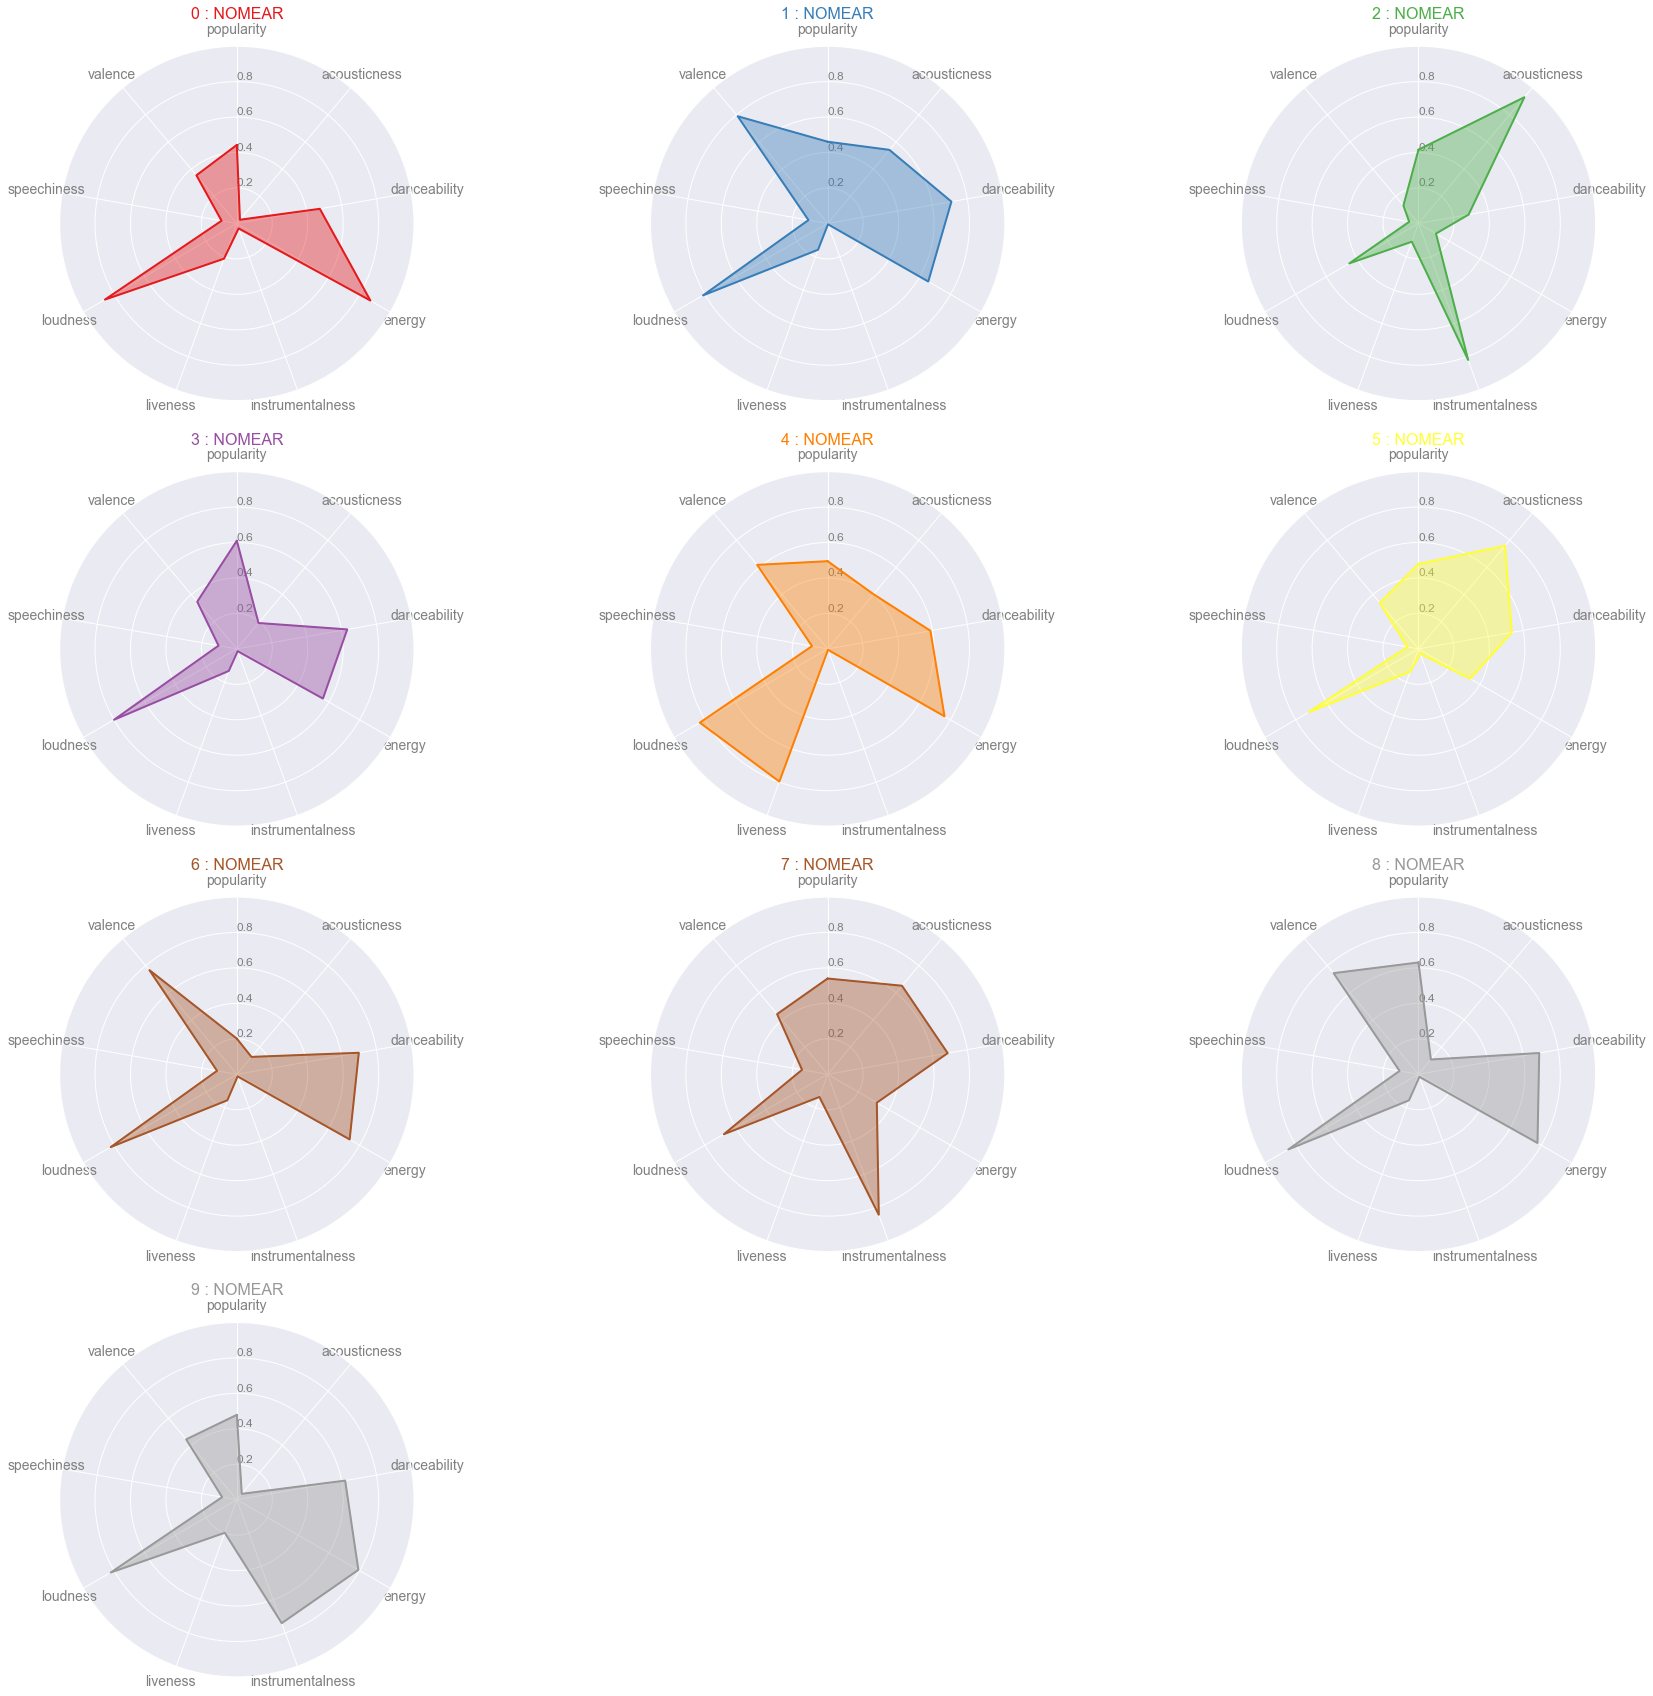

In [265]:
# initialize the figure
plt.figure(figsize=(30,30))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

# Create cluster name
title_list = ['NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 
              'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR',
              'NOMEAR', 'NOMEAR']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

### Aplicando PCA para visualizar os clusters

In [234]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.6612448741759881

In [235]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.216150,-0.396800,0.005520,1
1,-0.091717,-0.441951,-0.049434,1
2,0.757446,-0.008880,-0.266392,5
3,0.037356,0.043257,-0.021921,3
4,0.122819,-0.147323,0.043899,1


- Undersampling clusters

In [236]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

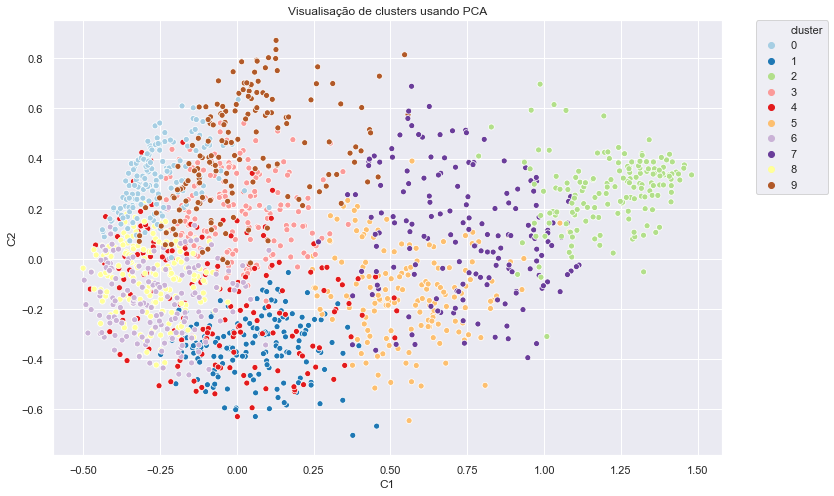

In [237]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando PCA')
plt.show()

- Scatter plot dos clusters em 3 dimensões

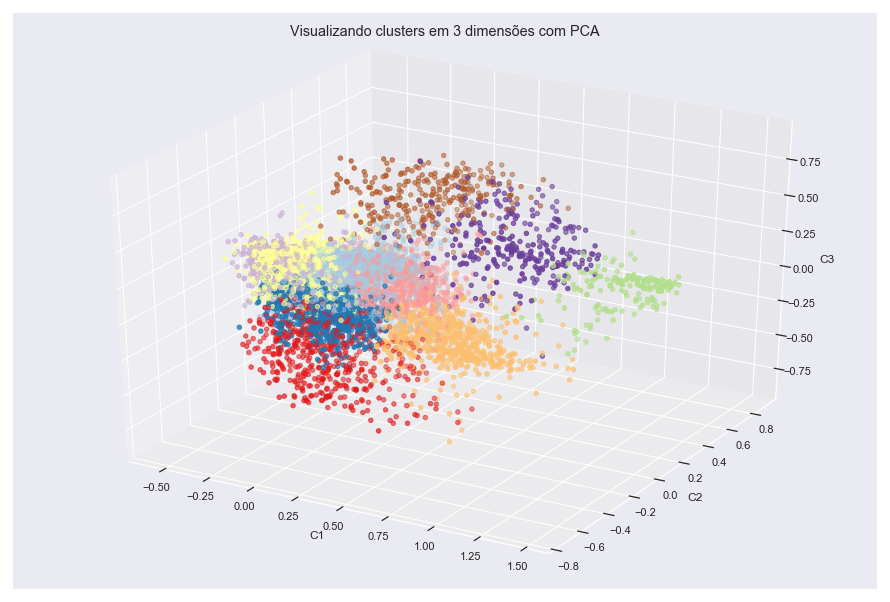

In [238]:
fig = plt.figure()
fig.suptitle('Visualizando clusters em 3 dimensões com PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

### Aplicando t-SNE para visualizar os clusters

In [239]:
#tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42, learning_rate=190)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [240]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-31.075190,31.513802,1
1,-32.949272,34.356548,1
2,24.878963,55.671089,5
3,14.289061,7.539682,3
4,8.682300,27.052135,1


- Undersampling clusters

In [241]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

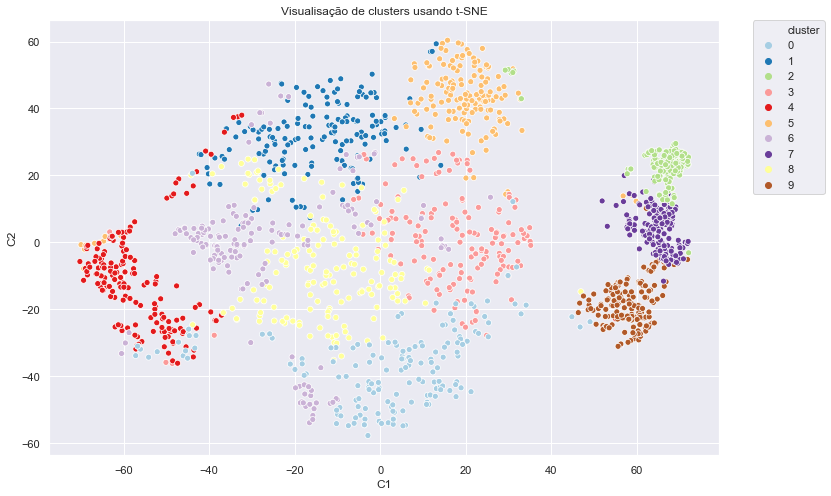

In [242]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando t-SNE')
plt.show()

### Prevendo os clusters do usuário

In [271]:
user_pred = model.predict(user_scaled)
print('10 primeiros clusters do usuário: ', user_pred[:10])

10 primeiros clusters do usuário:  [0 3 0 3 9 3 9 9 5 8]


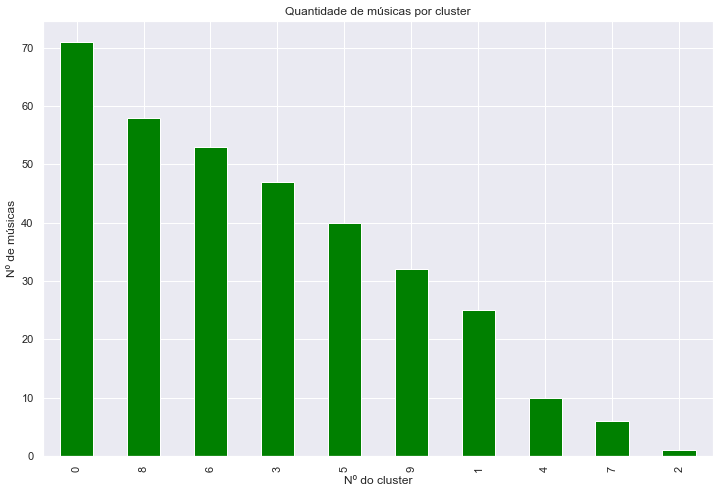

In [272]:
user_cluster = pd.DataFrame(user_scaled, columns=columns_to_cluster_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Nº do cluster')
plt.ylabel('Nº de músicas')
plt.title('Quantidade de músicas por cluster')
plt.show()

In [273]:
df_user_songs_joined = pd.concat([df_user,user_cluster], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,The Kooks,See The World,Inside In / Inside Out
0,Foo Fighters,Everlong,The Colour And The Shape
0,Kasabian,L.S.F.,Kasabian/Empire
0,Karma Fields,Build the Cities (feat. Kerli),Build the Cities (feat. Kerli)
0,The Kooks,Is It Me,The Best Of... So Far
0,The Duke Spirit,Surrender,Bruiser
0,Grant Bowtie,High Tide,High Tide
0,Matanza,Bom É Quando Faz Mal,Fundamental - Matanza
0,Jamie N Commons,Nina,The Baron


,artist,name,album
cluster,,,
3,Bonobo,Kiara,Black Sands
3,Ne-Yo,Let Me Love You (Until You Learn To Love Yours...,R.E.D. (Deluxe Edition)
3,Jack Johnson,Better Together,In Between Dreams
3,Nick Murphy / Chet Faker,Gold,Built on Glass
3,Pearl Jam,Black,Ten
3,It Looks Sad.,Nagoya,Kaiju
3,The White Stripes,Seven Nation Army,Elephant
3,Flying Lotus,"Coronus, the Terminator",You're Dead!
3,Peach Pit,Tommy's Party,Being So Normal


,artist,name,album
cluster,,,
9,Yuck,Get Away,Yuck
9,No Vacation,Yam Yam,Yam Yam
9,Silversun Pickups,Lazy Eye,Carnavas
9,Snarky Puppy,Outlier,We Like It Here
9,The Avalanches,If I Was A Folkstar,Wildflower
9,Deon Custom,Roses,Roses
9,Ratatat,Loud Pipes,Classics
9,Bonobo,Flashlight,Flashlight EP
9,Parquet Courts,Human Performance,Human Performance


,artist,name,album
cluster,,,
5,Paolo Nutini,Chamber Music,Sunny Side Up
5,Gregory Alan Isakov,The Stable Song,"That Sea, The Gambler"
5,Eddie Vedder,Rise,Music For The Motion Picture Into The Wild
5,Led Zeppelin,Stairway to Heaven - 1990 Remaster,Led Zeppelin IV
5,J. Cole,Change,4 Your Eyez Only
5,Jamie N Commons,Lead Me Home - The Walking Dead Soundtrack,The Walking Dead (AMC’s Original Soundtrack – ...
5,Pearl Jam,Just Breathe,Backspacer
5,The xx,Crystalised,xx
5,Kid Bloom,"I Kissed a Girl, and She Kissed Me",A Different State of Mind


,artist,name,album
cluster,,,
8,Peach Pit,Not Me,Being So Normal
8,The Kooks,Naive,Inside In / Inside Out
8,Ratatat,Wildcat,Classics
8,The Enemy,Away from Here,We'll Live and Die In These Towns
8,Anderson .Paak,Come Down,Malibu
8,Jay Prince,"Father, Father",Smile Good
8,Jungle,The Heat,Jungle
8,AC/DC,Back In Black,Back In Black
8,Charlie Brown Jr.,O Côro Vai Comê,A Arte De Charlie Brown Jr.


,artist,name,album
cluster,,,
6,Graveyard,Magnetic Shunk,Innocence & Decadence
6,Jamie T,Zombie,Carry On The Grudge
6,Grant Bowtie,Clockwork,Clockwork
6,The Kooks,You Don't Love Me,The Best Of... So Far
6,Loyle Carner,Stars & Shards,Yesterday's Gone
6,Eddie Vedder,Hard Sun,Music For The Motion Picture Into The Wild
6,Peter Bjorn and John,Young Folks,Electracoustic (Electronic Acoustic)
6,Childish Gambino,The Palisades,Kauai
6,The Game,Hate It Or Love It,The Documentary


,artist,name,album
cluster,,,
1,Thundercat,Them Changes,The Beyond / Where the Giants Roam
1,GoldLink,Herside Story,At What Cost
1,Vingadora,Paredão Metralhadora,Vem Ne Mim
1,MC Kevinho,O Grave Bater,O Grave Bater
1,Jim Croce,I Got a Name,The Definitive Croce
1,Ne-Yo,Because Of You,Because Of You
1,Charlie Brown Jr.,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,Imunidade Musical
1,Nick Murphy / Chet Faker,No Diggity,Thinking In Textures
1,Oberhofer,Gold,Time Capsules II


,artist,name,album
cluster,,,
4,Nando Reis,Os Cegos do Castelo - Ao Vivo,Nando Reis - Voz e Violão - No Recreio - Vol. ...
4,Jungle,Time,Jungle
4,Youngblood Brass Band,Brooklyn,Live. Places.
4,Stephen,Crossfire,Sincerely
4,Kasabian,Underdog,West Ryder Pauper Lunatic Asylum
4,Justin Timberlake,What Goes Around.../...Comes Around (Interlude),FutureSex/LoveSounds
4,Snarky Puppy,Sleeper,We Like It Here
4,Vespas Mandarinas,O Vício e o Verso - Ao Vivo,Animal Nacional Ao Vivo
4,Kendrick Lamar,Ab-Souls Outro,Section.80


album     Lies We Told
artist    Fallen Roses
name      Lies We Told
Name: 2, dtype: object

,artist,name,album
cluster,,,
7,Fallen Roses,Yours and Nobody Else's,Yours and Nobody Else's
7,Bonobo,Black Sands,Black Sands
7,Jungle,Drops,Jungle
7,The xx,Sunset,Coexist
7,Flying Lotus,Tiny Tortures,Until The Quiet Comes
7,Tycho,Spectre,Awake


### Recomendando músicas

In [274]:
df_user_songs_joined.reset_index(inplace=True)
cluster_pct = df_user_songs_joined.cluster.value_counts(normalize=True)*100
cluster_pct

0    20.699708
8    16.909621
6    15.451895
3    13.702624
5    11.661808
9     9.329446
1     7.288630
4     2.915452
7     1.749271
2     0.291545
Name: cluster, dtype: float64

In [275]:
df_songs_joined.reset_index(inplace=True)
df_songs_joined.head(3)

,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,0,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,...,0.933,0.37,0.412650,0.678899,0.859824,0.000000,0.302758,0.891080,0.033628,0.948171
1,1,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,...,0.871,0.38,0.566264,0.720693,0.851814,0.000095,0.319285,0.863885,0.035619,0.885163
2,2,5,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,...,0.180,0.00,0.804217,0.304791,0.158944,0.000000,0.041525,0.596297,0.039491,0.182927


In [276]:
df_user_songs_joined['cluster_pct'] = df_user_songs_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_songs_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_songs_joined.head(3)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_pct
0,0,Self-Titled,7jhH139X9JCMwKlW0SWwLY,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,228000,71QKtFaECvOxpvHk105FMw,Ocean,38,0.002000,...,0.723,0.00378,9,0.0589,-6.485,1,0.0420,122.003,0.348,20.699708
1,3,Kaiju,0Z0fNb1sXiQ7oULwQYZMUA,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,230653,3GHB3jMQPJ6Q97JKbZCowT,Nagoya,46,0.000725,...,0.569,0.20600,7,0.0873,-8.497,1,0.0251,150.178,0.215,13.702624
2,0,Sweet FA,1lhF5c8Q9bzYNwGFwQgYnP,Peach Pit,6fC2AcsQtd9h4BWELbbire,287080,0ZK8TGOsngrstVPsnrHbK1,Peach Pit,68,0.003220,...,0.804,0.00229,6,0.1490,-5.345,0,0.0398,123.969,0.298,20.699708


In [277]:
playlist = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_songs_joined[df_songs_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)), random_state=42)
    playlist = pd.concat([playlist,songs], ignore_index=True)
playlist.head(3)

,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,5394,0,lovehatetragedy,79t2bX5lRZEWS3xukAdVQj,Papa Roach,4RddZ3iHvSpGV4dvATac9X,209572,1FkgHW6Rnravvt6uVd3DGB,She Loves Me Not,4,...,0.390,0.04,0.001032,0.612640,0.954943,0.000000,0.284165,0.875510,0.088274,0.396341
1,5734,0,Download Hatred,5MNjmehRdr9sunslNw0SaX,Claustrofobia,6qQ1oR8882plR1Iwfuh179,224986,7ER8xO4Gn5fm4WPxMva1JX,Blasphemous Corruption,24,...,0.165,0.24,0.000007,0.259939,0.991990,0.438900,0.805805,0.816712,0.190265,0.167683
2,5897,0,A Million In Prizes: Iggy Pop Anthology (Edite...,39vZUsVRUvo1l2HwR7Cfpg,Iggy Pop,33EUXrFKGjpUSGacqEHhU4,312040,0kvH59HS2T2m4bsXJhBGNC,Lust For Life,48,...,0.714,0.48,0.006745,0.379205,0.976971,0.000003,0.141618,0.879641,0.053429,0.725610


### EDA usuário vs nova playlist

In [280]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
index               100 non-null int64
cluster             100 non-null int64
album               100 non-null object
album_id            100 non-null object
artist              100 non-null object
artist_id           100 non-null object
duration_ms         100 non-null int64
id                  100 non-null object
name                100 non-null object
popularity          100 non-null int64
acousticness        100 non-null float64
danceability        100 non-null float64
energy              100 non-null float64
instrumentalness    100 non-null float64
key                 100 non-null int64
liveness            100 non-null float64
loudness            100 non-null float64
mode                100 non-null int64
speechiness         100 non-null float64
tempo               100 non-null float64
valence             100 non-null float64
dtypes: float64(9), int64(6), object(6)
memory usage:

In [281]:
playlist[['name', 'artist', 'album', 'cluster']]

,name,artist,album,cluster
0,She Loves Me Not,Papa Roach,lovehatetragedy,0
1,Blasphemous Corruption,Claustrofobia,Download Hatred,0
2,Lust For Life,Iggy Pop,A Million In Prizes: Iggy Pop Anthology (Edite...,0
3,Laid to Rest,Lamb of God,Ashes Of The Wake,0
4,여름날 (Hi Ya Ya) - Rearranged,TVXQ!,TVXQ! THE 4th WORLD TOUR 'Catch Me' LIVE ALBUM,0
5,Push It,Static-X,Wisconsin Death Trip,0
6,You're All I Need,Mötley Crüe,"Girls, Girls, Girls",0
7,Sugar,System Of A Down,System Of A Down,0
8,I'll Be Right Here,The Slow Death,I'll Be Right Here / Factory,0
9,Hope For The Underrated Youth,YUNGBLUD,Hope For The Underrated Youth,0


In [282]:
playlist.describe()

,index,cluster,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3468.660000,4.420000,214755.540000,50.220000,0.240211,0.580110,0.680240,0.097143,5.180000,0.217731,-7.257220,0.700000,0.092577,123.724510,0.528082
std,1966.718413,3.150052,53549.848851,23.320594,0.281372,0.179192,0.228517,0.236253,3.652535,0.184418,3.520551,0.460566,0.106531,27.672747,0.247866
min,104.000000,0.000000,82962.000000,0.000000,0.000009,0.212000,0.154000,0.000000,0.000000,0.029500,-20.801000,0.000000,0.023600,61.284000,0.039300
25%,1752.250000,1.000000,179720.500000,33.000000,0.006425,0.450250,0.512000,0.000000,2.000000,0.105500,-9.224500,0.000000,0.038475,102.208250,0.358250
50%,3482.500000,5.000000,211975.500000,55.000000,0.118000,0.603000,0.723500,0.000010,5.000000,0.148000,-6.638000,1.000000,0.054400,123.574500,0.525000
75%,5450.750000,8.000000,248659.500000,67.000000,0.386250,0.701500,0.889500,0.011375,9.000000,0.299250,-4.380000,1.000000,0.091900,142.213000,0.714000
max,6446.000000,9.000000,366136.000000,98.000000,0.943000,0.951000,0.991000,0.940000,11.000000,0.962000,-2.399000,1.000000,0.685000,176.169000,0.968000


- Comparar features entre user x playlist

In [283]:
def plot_recomendations_similarities(data, variables):
    root = int(np.ceil(np.sqrt(len(variables))))
    fig, axis = plt.subplots(nrows=root, ncols=root, figsize=(15, 15))
    
    numeric_categories = ["0.0 - 0.2",
                           "0.2 - 0.4",
                           "0.4 - 0.6",
                           "0.6 - 0.8",
                           "0.8 - 1.0",
                           ]
    fig.suptitle('Comparando distribuicoes para as caracteristicas das musicas')
    for idx, column in enumerate(variables):
        i, j = idx % root, idx // root
        ax = axis[j][i]
        
        grouped = data.groupby('user')[[column, 'user']]
        
        for user, group in grouped:
            sns.distplot(group[column], ax=ax, label=user, bins=20)
        ax.legend()
    plt.show()

In [284]:
df_user_songs_joined['user'] = 'User'
playlist['user'] = 'Playlist'

user = df_user_songs_joined.drop(columns='cluster_pct')

display(user.head(1))
playlist.head(1)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,user
0,0,Self-Titled,7jhH139X9JCMwKlW0SWwLY,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,228000,71QKtFaECvOxpvHk105FMw,Ocean,38,0.002,...,0.723,0.00378,9,0.0589,-6.485,1,0.042,122.003,0.348,User


,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,user
0,5394,0,lovehatetragedy,79t2bX5lRZEWS3xukAdVQj,Papa Roach,4RddZ3iHvSpGV4dvATac9X,209572,1FkgHW6Rnravvt6uVd3DGB,She Loves Me Not,4,...,0.954,0.0,2,0.296,-4.507,1,0.0798,119.12,0.39,Playlist


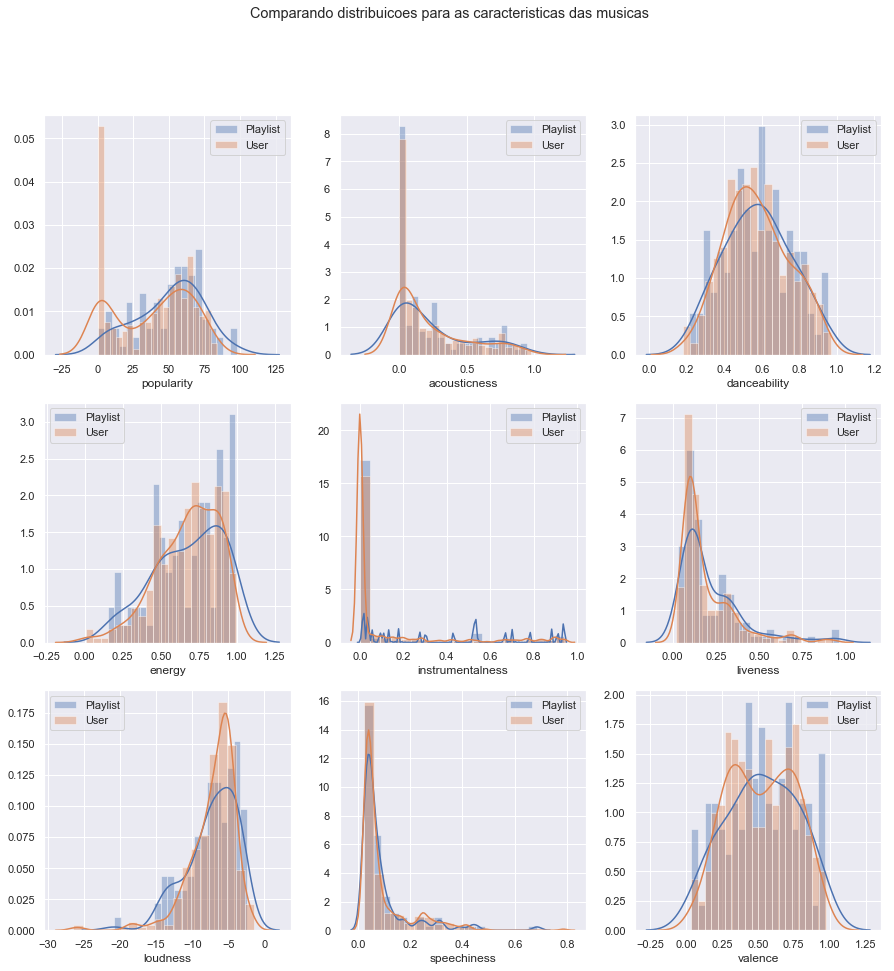

In [285]:
user_x_playlist = user.append(playlist)
plot_recomendations_similarities(user_x_playlist, columns_to_cluster)

### Exportando playlist gerada

- Para csv

In [279]:
playlist.drop(columns=columns_to_cluster_scaled, inplace=True)
playlist.to_csv('datasets/generated_playlists/belzedu_playlist.csv', index=False)

- Para o Spotify

- Distribução dos clusters em relação ao dataset original

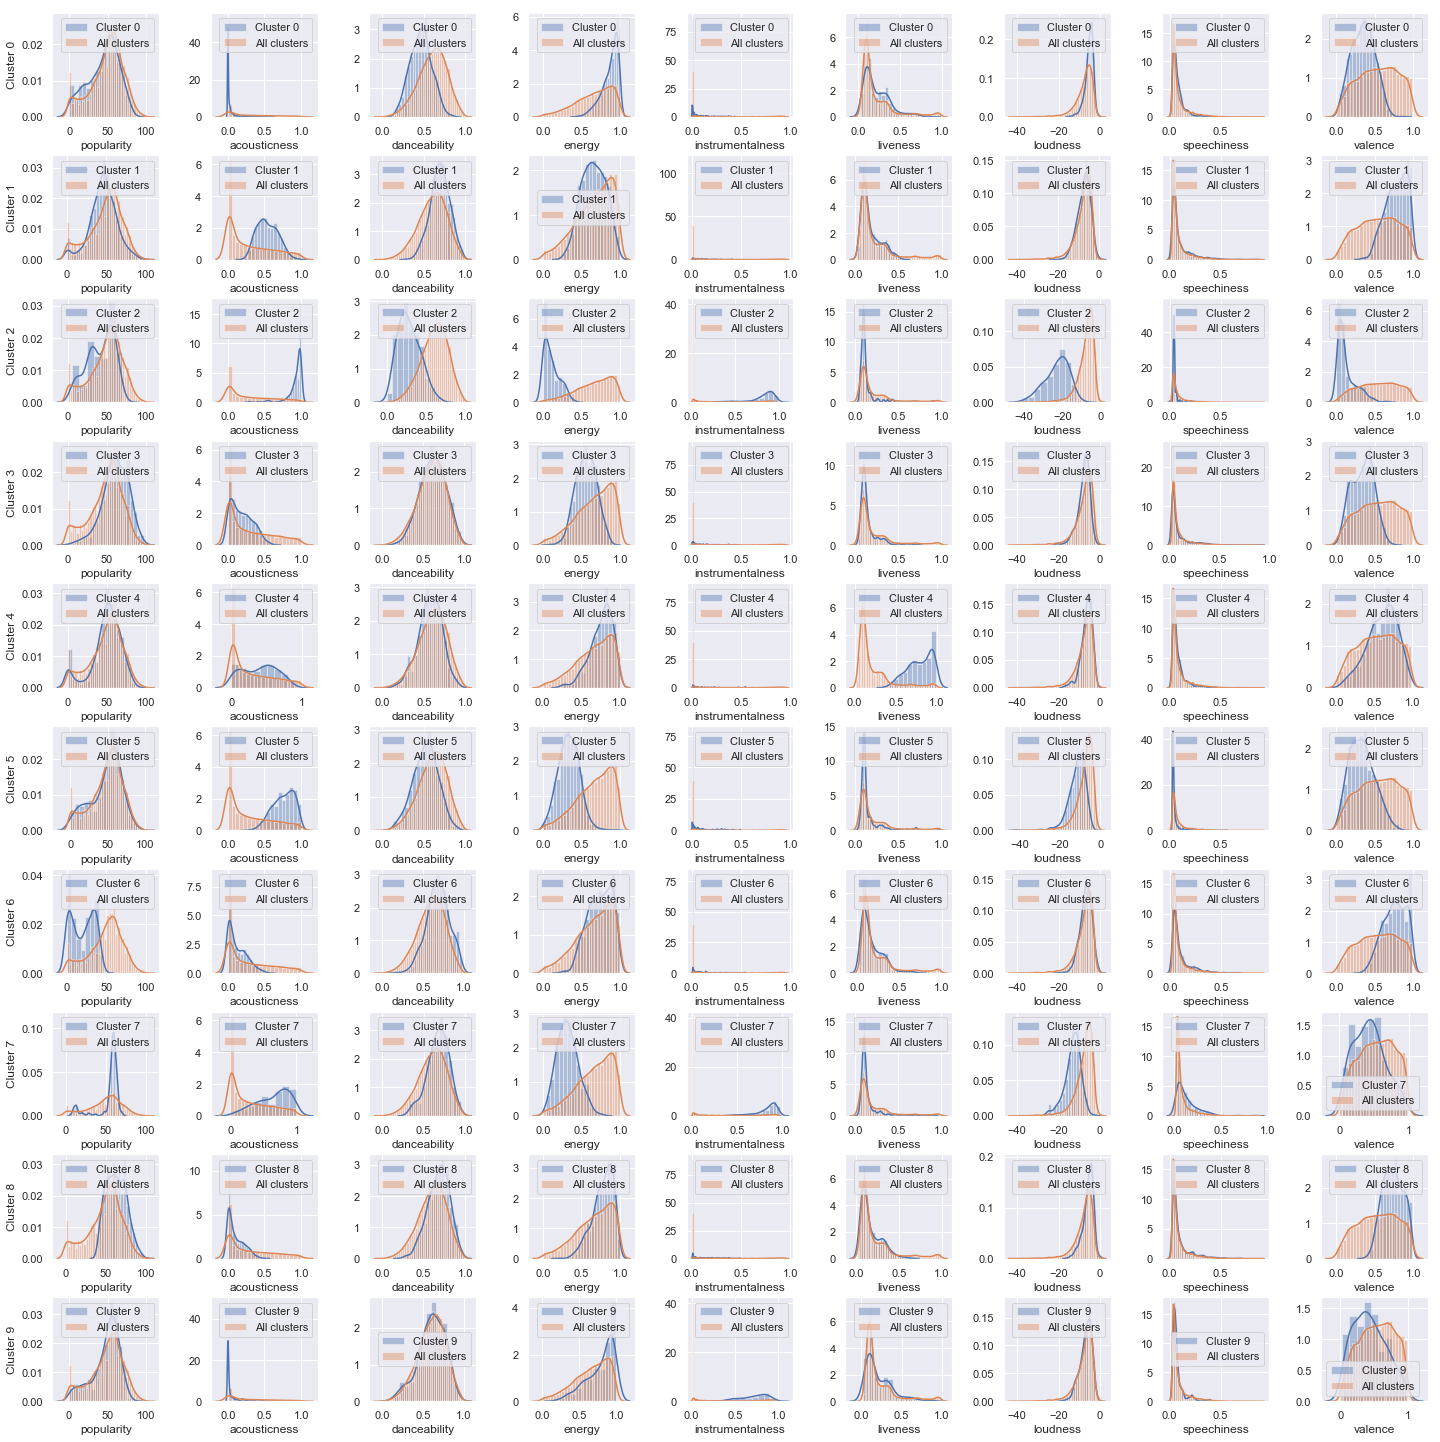

In [224]:
def plot_similarities(data, variables, n_clusters):
    fig, axis = plt.subplots(nrows=n_clusters, ncols=len(variables), figsize=(20, 20))
    #fig.suptitle('Comparando distribuicoes para as caracteristicas das musicas')
    plt.tight_layout()
    for k in range(n_clusters):
        for idx, column in enumerate(variables):
            ax = axis[k][idx]
            sns.distplot(data.loc[k,column], ax=ax, label='Cluster {}'.format(k))
            sns.distplot(data[column], ax=ax, label='All clusters')
            ax.legend()
        ax = axis[k][0]
        ax.set_ylabel('Cluster {}'.format(k))
        
plot_similarities(df_songs_joined, columns_to_cluster, k)